## BTC price forecasting with Deep Learning

In [2]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Loading/Reading in the Data
df = pd.read_csv("./data/price/BTC-USD.csv", sep=';')

In [3]:
# Data Preprocessing
# Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
df = df.set_index("Index")[['BTC-USD.Adjusted']]
df = df.set_index(pd.to_datetime(df.index))

# Leave the last 30 values for estimation
df = df[:-30]

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

**Some help functions**

In [4]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

**Create model**

In [5]:
# How many periods looking back to train
n_per_in  = 30

# How many periods ahead to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(df['BTC-USD.Adjusted'].tolist(), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [16]:
# Instantiating the model
model = Sequential()

# Activation
activ = "softsign"

# Input layer
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))
# Hidden layers
model.add(LSTM(90, activation=activ, return_sequences=True))
model.add(Dropout(0.3))
#model.add(LSTM(45, activation=activ, return_sequences=True))
#model.add(Dropout(0.2))

# Final Hidden layer
model.add(LSTM(10, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 90)            43560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 90)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10)                4040      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
Total params: 51,550
Trainable params: 51,550
Non-trainable params: 0
_________________________________________________________________


**Complie model**

In [18]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae', 'acc'])

**Fit model**

In [20]:
from keras.callbacks import ModelCheckpoint

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

res = model.fit(X, y, epochs=100, batch_size=64, validation_split=0.2, callbacks=[checkpoint])

Train on 1119 samples, validate on 280 samples
Epoch 1/100
1119/1119 [==============================] - 1s 1ms/step - loss: 0.0027 - mae: 0.0281 - acc: 0.1189 - val_loss: 0.0029 - val_mae: 0.0376 - val_acc: 0.1143

Epoch 00001: val_acc improved from -inf to 0.11429, saving model to weights.best.hdf5
Epoch 2/100
1119/1119 [==============================] - 1s 1ms/step - loss: 0.0028 - mae: 0.0283 - acc: 0.1135 - val_loss: 0.0026 - val_mae: 0.0366 - val_acc: 0.0714

Epoch 00002: val_acc did not improve from 0.11429
Epoch 3/100
1119/1119 [==============================] - 1s 1ms/step - loss: 0.0026 - mae: 0.0276 - acc: 0.1278 - val_loss: 0.0033 - val_mae: 0.0404 - val_acc: 0.1036

Epoch 00003: val_acc did not improve from 0.11429
Epoch 4/100
1119/1119 [==============================] - 2s 1ms/step - loss: 0.0025 - mae: 0.0264 - acc: 0.1224 - val_loss: 0.0025 - val_mae: 0.0358 - val_acc: 0.1143

Epoch 00004: val_acc did not improve from 0.11429
Epoch 5/100
1119/1119 [======================

1119/1119 [==============================] - 1s 1ms/step - loss: 0.0015 - mae: 0.0214 - acc: 0.1421 - val_loss: 0.0036 - val_mae: 0.0419 - val_acc: 0.1857

Epoch 00074: val_acc did not improve from 0.28214
Epoch 75/100
1119/1119 [==============================] - 1s 1ms/step - loss: 0.0012 - mae: 0.0203 - acc: 0.1287 - val_loss: 0.0036 - val_mae: 0.0401 - val_acc: 0.2036

Epoch 00075: val_acc did not improve from 0.28214
Epoch 76/100
1119/1119 [==============================] - 1s 1ms/step - loss: 0.0011 - mae: 0.0199 - acc: 0.1483 - val_loss: 0.0040 - val_mae: 0.0431 - val_acc: 0.1643

Epoch 00076: val_acc did not improve from 0.28214
Epoch 77/100
1119/1119 [==============================] - 1s 1ms/step - loss: 0.0012 - mae: 0.0201 - acc: 0.1323 - val_loss: 0.0032 - val_mae: 0.0394 - val_acc: 0.1679

Epoch 00077: val_acc did not improve from 0.28214
Epoch 78/100
1119/1119 [==============================] - 1s 1ms/step - loss: 0.0011 - mae: 0.0197 - acc: 0.1492 - val_loss: 0.0035 - val

**Visualize training results**

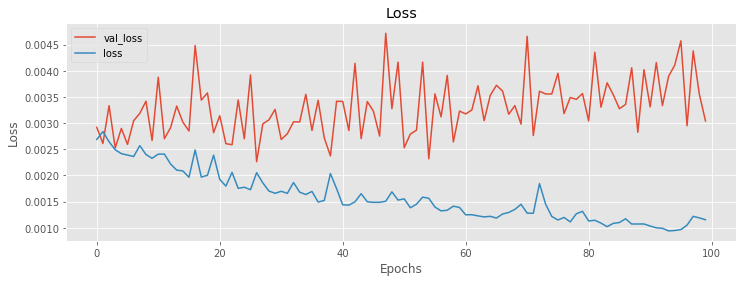

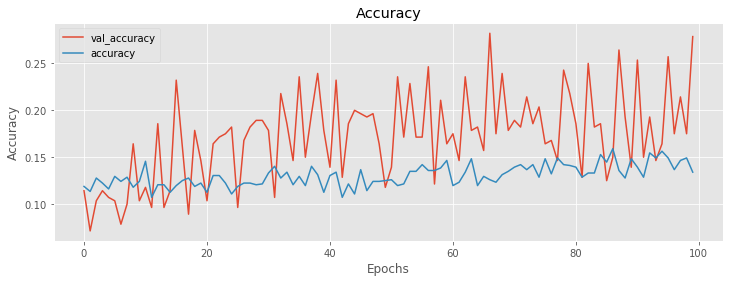

In [21]:
visualize_training_results(res)

Predicted Prices:
 [[8731.425300410041], [8710.08459073006], [8858.953379789362], [8682.5400404688], [8762.88653480035], [9046.637666404826], [8733.847062578665], [9007.830153933533], [8998.728297907417], [9068.383904323595]]

Actual Prices:
 [[9427.6875], [9205.726563], [9199.584961], [9261.104492], [9324.717773], [9235.354492], [9412.612305], [9342.527344], [9360.879883], [9267.561523]]


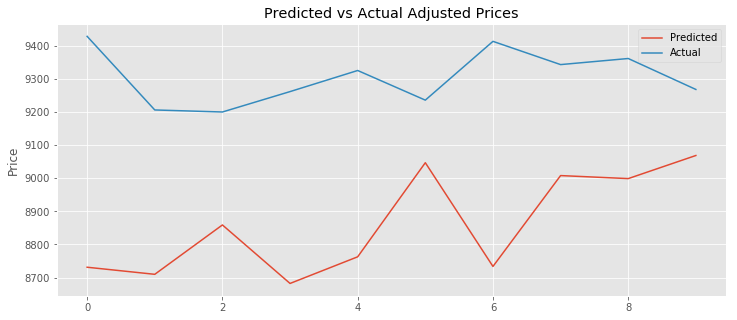

In [22]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Adjusted Prices")
plt.ylabel("Price")
plt.legend()
#plt.savefig("BTC_validation.png")
plt.show()

            BTC-USD.Adjusted
2019-11-07       9490.489750
2019-11-08       9555.954898
2019-11-09       9542.353446
2019-11-10       9529.579592
2019-11-11       9531.756098
2019-11-12       9417.780419
2019-11-13       9343.289843
2019-11-14       9375.158887
2019-11-15       9358.929773
2019-11-16       9260.219865


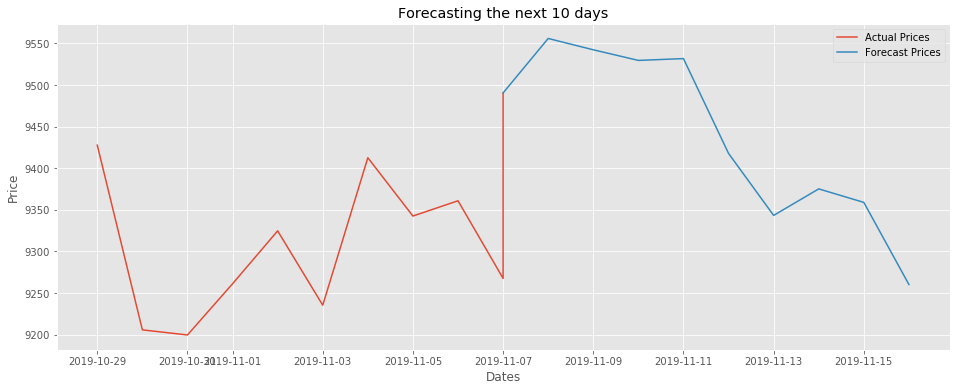

In [26]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[['BTC-USD.Adjusted']].tail(pers)), index=df['BTC-USD.Adjusted'].tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Forecast Prices")

plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
#plt.savefig("BTC_predictions.png")
plt.show()

In [31]:
preds

,BTC-USD.Adjusted
2019-11-07,9490.489750
2019-11-08,9555.954898
2019-11-09,9542.353446
2019-11-10,9529.579592
2019-11-11,9531.756098
2019-11-12,9417.780419
2019-11-13,9343.289843
2019-11-14,9375.158887
2019-11-15,9358.929773
2019-11-16,9260.219865
